In [33]:
import warnings
import numpy as np
import pandas as pd
import yfinance as yf
import plotly.offline as py
import seaborn as sns
import matplotlib.pyplot as plt
#from prophet import Prophet
#from xgboost import XGBRegressor
#from sklearn.preprocessing import RobustScaler
#from sklearn.linear_model import Ridge, Lasso
#from sklearn.ensemble import GradientBoostingRegressor
#from utilities.evaluation import RegressionEvaluator
#from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
#from utilities.time_series import create_lags_features, create_date_features

#py.init_notebook_mode()
pd.options.plotting.backend = "plotly"
warnings.filterwarnings(action="ignore")
pd.set_option("float_format", "{:.2f}".format)

### Analisis exploratorio de datos

In [16]:
cop = yf.Ticker(ticker="COP=X").history(start="2016-01-01", end="2021-12-31")
cop.head(n=5).append(cop.tail(n=5))

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2016-01-01,3138.00,3138.00,3136.70,3137.30,0,0,0
2016-01-04,3141.60,3223.00,3128.70,3154.80,0,0,0
2016-01-05,3215.00,3215.00,3153.70,3173.90,0,0,0
2016-01-06,3174.50,3256.00,3163.90,3254.00,0,0,0
2016-01-07,3163.80,3289.00,3163.80,3271.00,0,0,0
2021-12-27,3989.75,3996.25,3979.25,3989.75,0,0,0
2021-12-28,3995.08,4004.47,3956.04,3995.08,0,0,0
2021-12-29,4007.42,4024.50,4006.63,4007.42,0,0,0
2021-12-30,4036.12,4038.31,3990.58,4036.12,0,0,0


In [17]:
idx = cop.query("Close < 100").index
cop.loc[idx, "Close"] = np.nan

In [18]:
date_range = pd.date_range(start="1/1/2016", end="12/31/2021")
cop.reset_index(inplace=True)
cop.columns = [col.lower() for col in cop.columns.tolist()]

data = pd.DataFrame(data={"date": date_range})
data = pd.merge(left=data, right=cop[["date", "close"]], on=["date"], how="left")
data.head().append(data.tail())

,date,close
0,2016-01-01,3137.30
1,2016-01-02,NaN
2,2016-01-03,NaN
3,2016-01-04,3154.80
4,2016-01-05,3173.90
2187,2021-12-27,3989.75
2188,2021-12-28,3995.08
2189,2021-12-29,4007.42
2190,2021-12-30,4036.12
2191,2021-12-31,4068.25


In [25]:
data['day_of_week'] = data['date'].dt.dayofweek
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year

In [23]:
data['close'].interpolate(inplace=True)

In [26]:
data

,date,close,day_of_week,month,year
0,2016-01-01,3137.30,4,1,2016
1,2016-01-02,3143.13,5,1,2016
2,2016-01-03,3148.97,6,1,2016
3,2016-01-04,3154.80,0,1,2016
4,2016-01-05,3173.90,1,1,2016
...,...,...,...,...,...
2187,2021-12-27,3989.75,0,12,2021
2188,2021-12-28,3995.08,1,12,2021
2189,2021-12-29,4007.42,2,12,2021
2190,2021-12-30,4036.12,3,12,2021


### Violin Plot by Year, day of week and month

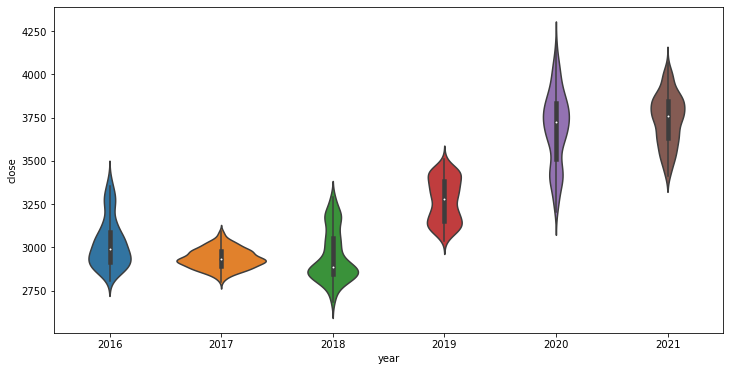

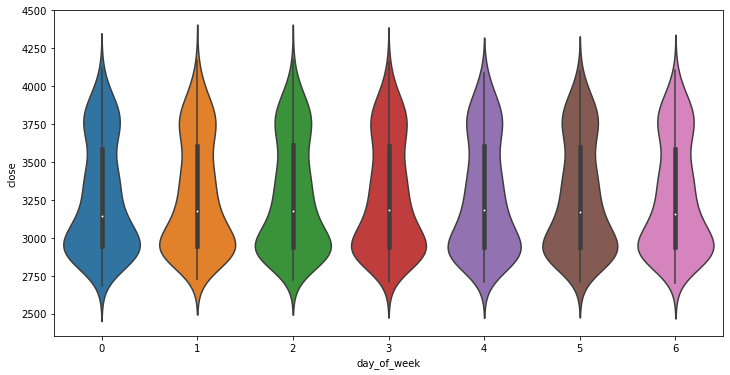

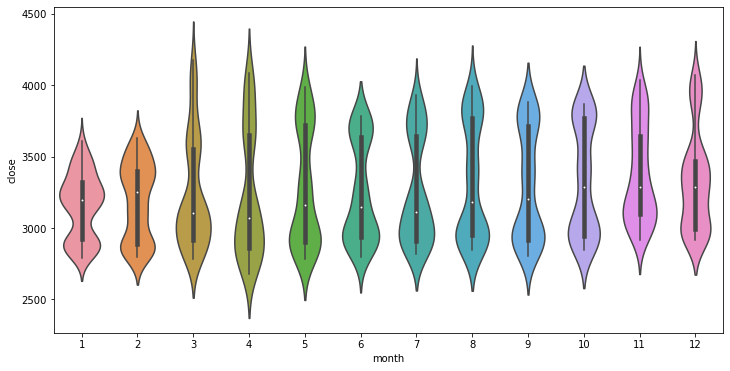

In [45]:
cols = ['year','day_of_week', 'month']

for i in cols:
    plt.figure(figsize=(12,6))
    sns.violinplot( data=data, x=i, y="close", innner = 'box')

### Estadisticas descriptivas

In [55]:
for i in cols:
    gb = data.groupby([i]).agg({'close':['mean','median','var','std']} )
    print(gb)

       close                        
        mean  median      var    std
year                                
2016 3025.59 2993.15 19991.89 141.39
2017 2936.42 2929.84  3248.17  56.99
2018 2948.83 2888.80 21416.49 146.34
2019 3272.69 3279.33 15725.23 125.40
2020 3689.23 3722.27 45882.06 214.20
2021 3739.60 3761.58 22235.09 149.11
              close                         
               mean  median       var    std
day_of_week                                 
0           3263.98 3146.70 132230.33 363.63
1           3274.35 3177.00 133623.87 365.55
2           3272.79 3178.30 133780.36 365.76
3           3271.46 3183.00 133521.98 365.41
4           3268.83 3182.12 135721.12 368.40
5           3265.51 3171.00 133209.17 364.98
6           3264.75 3158.00 132585.53 364.12
        close                         
         mean  median       var    std
month                                 
1     3156.96 3197.72  51107.11 226.07
2     3187.43 3248.50  70780.44 266.05
3     3242.82 3101.68 

### ACF AND PACF

In [56]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm

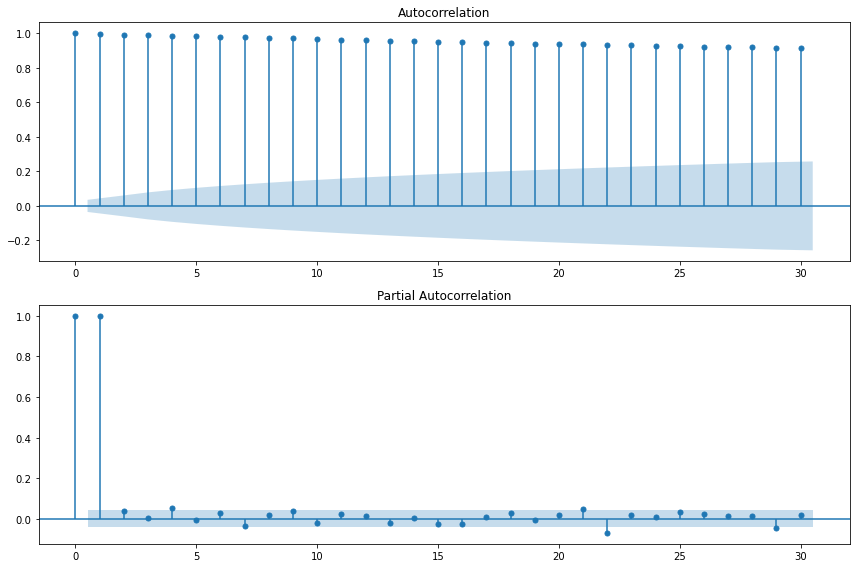

In [57]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

plot_acf(data['close'],lags=30, ax=ax[0], alpha = 0.1)
plot_pacf(data['close'],lags=30, ax=ax[1], method='ols', alpha = 0.05)

#ax[1].annotate('Strong correlation at lag = 1', xy=(1, 0.6),  xycoords='data',
#            xytext=(0.17, 0.75), textcoords='axes fraction',
#            arrowprops=dict(color='red', shrink=0.05, width=1))

plt.tight_layout()
plt.show()

### Box-cox transformation

In [58]:
from scipy.stats import boxcox

In [60]:
data['close_transform'], lam = boxcox(data['close'])

In [61]:
data

,date,close,day_of_week,month,year,close_transform
0,2016-01-01,3137.30,4,1,2016,0.39
1,2016-01-02,3143.13,5,1,2016,0.39
2,2016-01-03,3148.97,6,1,2016,0.39
3,2016-01-04,3154.80,0,1,2016,0.39
4,2016-01-05,3173.90,1,1,2016,0.39
...,...,...,...,...,...,...
2187,2021-12-27,3989.75,0,12,2021,0.39
2188,2021-12-28,3995.08,1,12,2021,0.39
2189,2021-12-29,4007.42,2,12,2021,0.39
2190,2021-12-30,4036.12,3,12,2021,0.39


Text(0, 0.5, 'Transform USD/COP lambda: -2.5395')

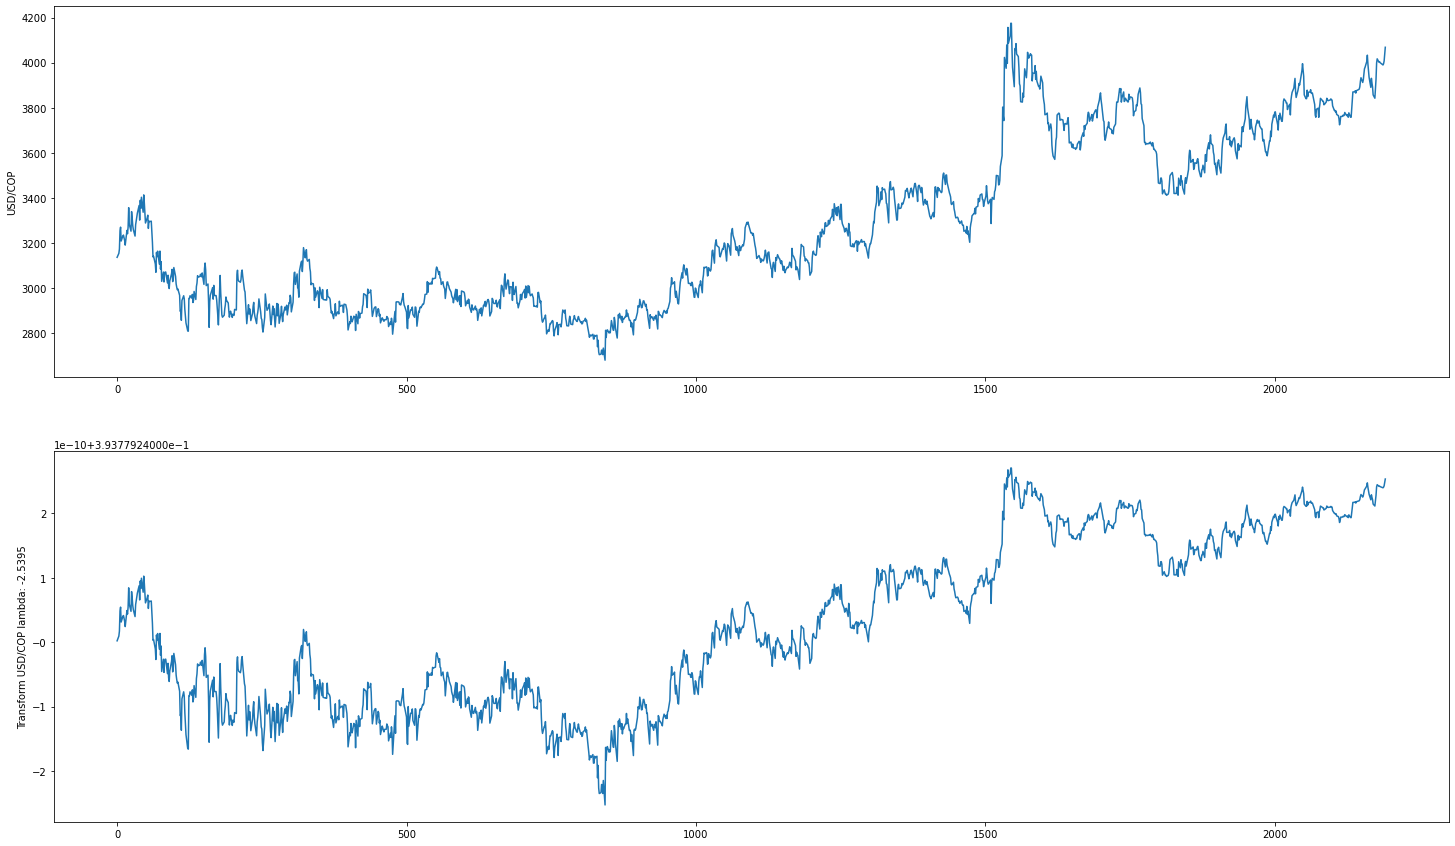

In [66]:
fig, (ax1, ax2) = plt.subplots(2, figsize = (25,15))

ax1.plot(data['close'])
ax1.set_ylabel('USD/COP')


ax2.plot(data['close_transform'])
ax2.set_ylabel('Transform USD/COP' + ' lambda: ' + str(round(lam,4)))